## Preamble: Libs + signal def

In [31]:
import itertools, importlib, sys, warnings, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML libs
import tensorflow as tf
from tensorflow.python import debug as tf_debug
print("Tensorflow version:", tf.__version__)

## suppress annoy verbose tf msgs
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # '3' to block all including error msgs
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Tensorflow version: 1.15.0


In [2]:
sys.path.append('./embodied_arch')
import embodied_arch.embodied_central_Qcritic as emac
importlib.reload(emac)

from embodied_misc import ActionPolicyNetwork, ValueNetwork, SensoriumNetworkTemplate
from embodied_arch.embodied_central_Qcritic import QsaNetwork

In [3]:
sys.path.append('./minoritygame')
import minoritygame.minority_multienv as MGME
importlib.reload(MGME) 


%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7,7)

log_path = './log/mingame'

## Setup k-vs-(N-k) Mingame Env

In [4]:
importlib.reload(MGME)

# n_agents = 61
# exos = (np.random.sample(n_agents) < 0.3)  # np.sum(exos)
# exos = [True, True, False, False, False, True]  # Majority subpop
# exos = [True, True, False, False, False, False]  # Minority subpop

exos = [True, True, True, False, False, False, False]  # Minority subpop
menv = MGME.MinorityGame_Multiagent_env(
    m=3, s=4,
    exo_actorsQ=exos
)

print(len(menv.actor_exoQ), menv.actor_count, menv.actor_index)
print(menv.state_space_size, menv.action_space_size)

7 3 [0, 1, 2]
3 1


## Setup MARL

In [5]:
# num_episodes, n_epochs, max_len = (100, 601, 251)
# num_episodes, n_epochs, max_len = (100, 751, 150)
num_episodes, max_len, n_epochs, evry = (100, 200, 751, 150)

In [6]:
actor = lambda s: ActionPolicyNetwork(s, hSeq=(32,), gamma_reg=1e-1)
value = lambda s: ValueNetwork(s, hSeq=(16,8,), gamma_reg=1.)
sensor = lambda st, out_dim: SensoriumNetworkTemplate(
    st, hSeq=(16,8,), 
    out_dim=out_dim, gamma_reg=5.
)

qsa = lambda sts, ats: QsaNetwork(
    sts, ats, 
    hSeq=(16,16,8,), gamma_reg=2.
)

In [7]:
tf.reset_default_graph()
importlib.reload(emac)

<module 'embodied_arch.embodied_central_Qcritic' from '/Users/oosoba/Documents/RAND/Coding/multiagent-ABM/embodied_arch/embodied_central_Qcritic.py'>

In [9]:
empopn = emac.EmbodiedAgent_MAC(
    name="mgMAC_k-vs-N-k", env_=menv, 
    alpha_p=50., alpha_v=12., alpha_q=3.,
    actorNN=actor, valueNN=value,
    latentDim=12, sensorium=sensor, QNN=qsa,
    max_episode_length=max_len, _every_=evry,
    CyclicSchedule=None #("log", 150)  #("exp", 150) #None #("log", 50)
)

In [ ]:
# empopn = emac.EmbodiedAgent_MAC( 
#     name=agent_name,
#     env_=MinorityGame_Multiagent_env,
#     latentDim=_zdim_,
#     space_size=(_s_size_, _a_size_),
#     sensorium=SensoriumNetworkTemplate,
#     actorNN=ActionPolicyNetwork,
#     valueNN=ValueNetwork,
#     QNN=QsaNetwork,
#     alpha_p=5e-2, alpha_v=1e-1, alpha_q=1e-1,
#     _every_=_every_, recover=None,
#     max_episode_length=_max_len_
# )

# print(empopn, empopn.s_size, empopn.a_size)

In [10]:
sess = tf.InteractiveSession()
empopn.init_graph(sess)  # note tboard log dir

Tensorboard logs in:  ./log/train_mgMAC_k-vs-N-k


In [11]:
## Verify step + play set up
state = empopn.env.reset()
# print(state, empopn.act(state, sess))

empopn.play(sess)
np.sum(np.array(empopn.episode_buffer['rewards']), axis=0)
# np.array(empopn.episode_buffer['rewards'])

array([75., 73., 67.])

In [12]:
print(empopn.last_total_returns/empopn.max_episode_length)
print(emac.summarize_np(empopn.last_total_returns))

[0.375 0.365 0.335]
(67.0, 71.66666666666667, 75.0)


### Pre-test Agent

In [14]:
print('Baselining untrained pnet...')
rwd_mg0 = []
acts_cov = np.zeros([empopn.actor_count,empopn.actor_count])
for k in range(num_episodes):
    empopn.play(sess, terminal_reward=0.)
    rwd_mg0.append(empopn.last_total_returns)
    actions = np.array(empopn.episode_buffer['actions']).T
    acts_cov = acts_cov + (np.cov(actions)/num_episodes)
    print("\rEpisode {}/{}".format(k, num_episodes),end="")

# Compute avg rewards
base_perf_mg = 100.*np.mean(np.array(rwd_mg0)/float(empopn.max_episode_length))
base_per_agent = 100.*np.mean(np.array(rwd_mg0)/float(empopn.max_episode_length), axis=0)

print("\nAgents win an average of {} pct".format(base_perf_mg))
print("\nPer Agent Win Pct: {} pct".format(base_per_agent))

Baselining untrained pnet...
Episode 99/100
Agents win an average of 37.01333333333333 pct

Per Agent Win Pct: [33.61  42.465 34.965] pct


Agent Action Correlations:


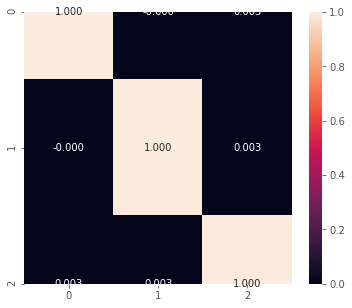

In [23]:
plt.rcParams['figure.figsize'] = (6,5)
acts_corr = acts_cov.copy()
jm, km = acts_corr.shape
for j in range(jm):
    for k in range(km):
        denom = np.sqrt((acts_corr[j,j])*(acts_corr[k,k]))
        acts_corr[j,k] = acts_corr[j,k]/denom

print("Agent Action Correlations:")
sns.heatmap(acts_corr, annot=True, fmt="0.3f")

## Train MARL Agents

	 Iteration 299: Q loss([5.730623  6.9219313 5.196987 ]))

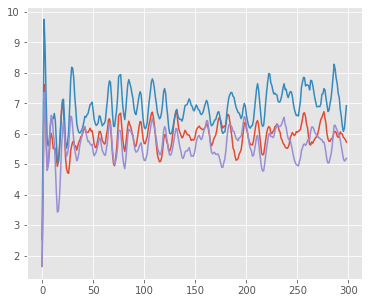

In [24]:
obs = []
for ct in range(300): #(1250):
    empopn.play(sess)
    tmp = empopn.train_eval_QC(sess)
    obs.append(np.mean(tmp, axis=0))
    print('\r\t Iteration {}: Q loss({})'.format(ct, np.mean(tmp, axis=0)), end="")
plt.plot(obs[1:]);

In [ ]:
# ### Train Agent w/ Algo on Experience Tuples
# Train pnet on mingame episodes
print('Training...')
saver = tf.train.Saver(max_to_keep=1)
hist = empopn.work(sess, num_epochs=n_epochs, saver=saver)

### Post-test Agent

In [26]:
# Test pnet!
print('Testing...')
rwd_mg = []
acts_cov = np.zeros([empopn.actor_count,empopn.actor_count])
for k in range(num_episodes):
    empopn.play(sess, terminal_reward=0.)
    rwd_mg.append(empopn.last_total_returns)
    actions = np.array(empopn.episode_buffer['actions']).T
    acts_cov = acts_cov + (np.cov(actions)/num_episodes)
    print("\rEpisode {}/{}".format(k, num_episodes),end="")

# Compute avg rewards
trained_perf_mg = 100.*np.mean(np.array(rwd_mg)/float(empopn.max_episode_length))
trained_per_agent = 100.*np.mean(np.array(rwd_mg)/float(empopn.max_episode_length), axis=0)

print("\nAgent wins an average of {} pct compared to baseline of {} pct".format(
    trained_perf_mg, base_perf_mg) )
print("\nPer Agent Win Pct: {} pct".format(trained_per_agent))

Testing...
Episode 99/100
Agent wins an average of 50.74666666666667 pct compared to baseline of 37.01333333333333 pct

Per Agent Win Pct: [48.425 52.37  51.445] pct


Trained Agent Action Correlations:


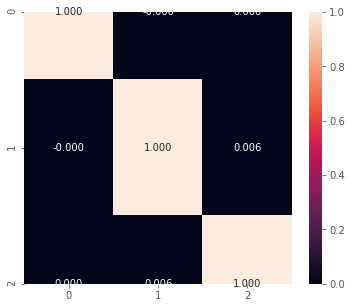

In [27]:
plt.rcParams['figure.figsize'] = (6,5)
acts_corr = acts_cov.copy()
jm, km = acts_corr.shape
for j in range(jm):
    for k in range(km):
        denom = np.sqrt((acts_corr[j,j])*(acts_corr[k,k]))
        acts_corr[j,k] = acts_corr[j,k]/denom

print("Trained Agent Action Correlations:")
sns.heatmap(acts_corr, annot=True, fmt="0.3f")

In [35]:
rwds0_df = pd.DataFrame(100.*(np.array(rwd_mg0)/float(empopn.max_episode_length)))
rwds_df = pd.DataFrame(100.*(np.array(rwd_mg)/float(empopn.max_episode_length)))

rwds0_df['Wave'] = "Baseline"
rwds_df['Wave'] = "Trained"

resDF = pd.concat([rwds0_df, rwds_df])
resDF.columns = ["Agent"+str(tc) if tc is not "Wave" else tc for tc in resDF.columns]
# resDF['id'] = resDF.index
print(resDF.shape)
# resDF.head()

resDF = resDF.melt(
    id_vars=['Wave'], #['id', 'Wave'],
    value_vars=[tc for tc in resDF.columns if "Agent" in tc]
)
resDF = resDF.rename(columns={"variable": "Agent", "value": "Win_pct"})
print(resDF.shape)
res_tabs = resDF.groupby(['Agent','Wave']).aggregate(['mean','std']) # res_tabs
# resDF.head()

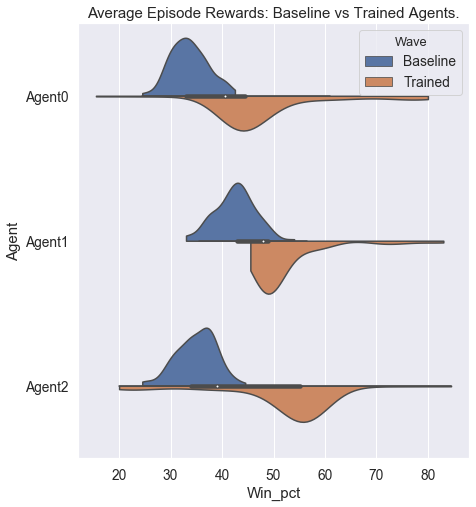

In [52]:
plt.rcParams['figure.figsize'] = (7, 8)
sns.set(font_scale=1.25)

fig = sns.violinplot(data=resDF, inner="box", cut=0,
                     x="Win_pct", y="Agent", hue="Wave",
                     split=True);
fig.set_title(
    'Average Episode Rewards: Baseline vs Trained Agents.');
# fig.legend(loc='upper left');

In [38]:
base_meanDF = resDF[resDF.Wave=="Baseline"].groupby(['Agent']).aggregate(['mean'])
base_meanDF.sort_index(inplace=True)

trained_meanDF = resDF[resDF.Wave=="Trained"].groupby(['Agent']).aggregate(['mean'])
trained_meanDF.sort_index(inplace=True)

mean_diffDF = (trained_meanDF - base_meanDF)
mean_diffDF.columns = ['Mean_Win_pct_Change']
# mean_diffDF.head()

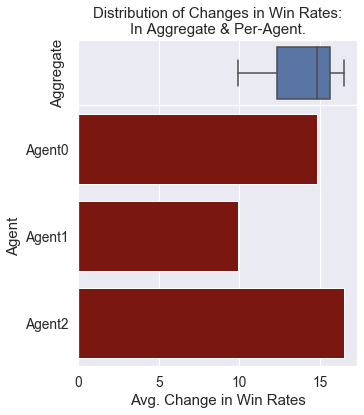

In [51]:
plt.rcParams['figure.figsize'] = (5, 6)
sns.set_color_codes("dark")
fig, axs = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [1,4]})
# cmp = sns.violinplot(x='Mean_Win_pct_Change', cut=0, inner='quartile',data=mean_diffDF, ax=axs[0])
cmp = sns.boxplot(x='Mean_Win_pct_Change',data=mean_diffDF, ax=axs[0])
axs[0].set_ylabel('Aggregate');
axs[0].set_title(
    'Distribution of Changes in Win Rates:\nIn Aggregate & Per-Agent.'
);

sns.barplot(y=mean_diffDF.index, x="Mean_Win_pct_Change", 
            data=mean_diffDF, color="r",
            label="Success Rate", ax=axs[1]);
plt.subplots_adjust(wspace=0, hspace=0)
axs[1].set_xlabel('Avg. Change in Win Rates');